# PilotNet SDNN Example

This tutorial explains how to perform inference on __lava-dl__ trained PilotNet SDNN network on both CPU as well as Loihi neurocore. At the core of this tutorial is lava-dl's __Network Exchange__ module which automatically generates native lava process from the training artifact that describes the trained network.

![PilotNet Inference](images/pilotnet_sdnn.PNG)

Network exchange module is available as `lava.lib.dl.netx.{hdf5, blocks, utils}`.
* `hdf5` implements automatic network generation.
* `blocks` implements individual layer blocks.
* `utils` implements hdf5 reading utilities. 

In addition, it also demonstrates how different lava processes can be connected with each other for real time interaction between them even though the underlying processes can be run on various backends, including Loihi 2.

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_conditions import RunSteps
from lava.proc import io

from lava.lib.dl import netx
from dataset import PilotNetDataset
from utils import (
    PilotNetEncoder, PilotNetDecoder, PilotNetMonitor,
    CustomHwRunConfig, CustomSimRunConfig,
    get_input_transform
)

# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [2]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'kp_stack'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    compression = io.encoder.Compression.DELTA_SPARSE_8
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")
    compression = io.encoder.Compression.DENSE


Running on kp_stack


## Create network block

PilotNet SDNN is described by the hdf5 file interface `network.net` exported after training. You can refer to the training tutorial that trains the networks and exports hdf5 file interface at [`tutorials/lava/lib/dl/slayer/pilotnet/train.ipynb`](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/slayer/pilotnet/train.ipynb)

A network block can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

![PilotNet Inference](images/pilotnet_sdnn_network.PNG)

In [3]:
net = netx.hdf5.Network(net_config='network.net', skip_layers=1)
print(net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Conv      |   99|   32|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   49|   15|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   48| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Dense     |    1|    1|  100|     |     |     |     |     |False|
|Dense     |    1|    1|   50|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|
|Dense     |    1|    1|    1|     |     |     |     |     |False|


In [4]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.__class__.__name__:5s} : {l.name:10s}, shape : {l.shape}')

There are 9 layers in network:
Conv  : Process_3 , shape : (99, 32, 24)
Conv  : Process_6 , shape : (49, 15, 36)
Conv  : Process_9 , shape : (24, 7, 48)
Conv  : Process_12, shape : (22, 4, 64)
Conv  : Process_15, shape : (20, 2, 64)
Dense : Process_18, shape : (100,)
Dense : Process_21, shape : (50,)
Dense : Process_24, shape : (10,)
Dense : Process_27, shape : (1,)


## Set execution parameters
Configure number of samples, execution timesteps, and readout offset.

In [5]:
num_samples = 200
steps_per_sample = 1
num_steps = num_samples + len(net.layers)
# Output appears delayed due to encoding and spike communication
out_offset = len(net.layers) + 3

## Create Dataset instance
Typically the user would write it or provide it.

In [6]:
transform = get_input_transform(net.net_config)
full_set = PilotNetDataset(
    path='../data',
    size=net.inp.shape[:2],
    transform=transform,  # input transform
    visualize=True,  # visualize ensures the images are returned in sequence
    sample_offset=10550,
)
train_set = PilotNetDataset(
    path='../data',
    size=net.inp.shape[:2],
    transform=transform,  # input transform
    train=True,
)
test_set = PilotNetDataset(
    path='../data',
    size=net.inp.shape[:2],
    transform=transform,  # input transform
    train=False,
)

## Create Dataloader
Dataloader process reads data from the dataset objects and sends out the input frame and ground truth as spikes.

![PilotNet Inference](images/pilotnet_sdnn_dataloader.PNG)

In [7]:
dataloader = io.dataloader.SpikeDataloader(dataset=full_set)

## Create Input Encoder

Input encoder does frame difference of subsequent frames to sparsify the input to the network.

For Loihi execution, it additionally takes care of compressing and sending the input data to the Loihi 2 chip.

![PilotNet Inference](images/pilotnet_sdnn_encoder.PNG)

In [8]:
input_encoder = PilotNetEncoder(shape=net.inp.shape,
                                net_config=net.net_config,
                                compression=compression)

## Create Output Decoder

Output decoder receives the output from the network and applies proper scaling to decode the steering angle prediction.

For Loihi execution, it additionally takes care of reveiving the raw output of the network from Loihi 2 chip.

![PilotNet Inference](images/pilotnet_sdnn_decoder.PNG)

In [9]:
output_decoder = PilotNetDecoder(shape=net.out.shape)

## Create Monitor and Dataloggers

Monitor is a process to visualize the PilotNet network prediction in real-time. In addition, dataloggers store the network predictions and ground truths.

![PilotNet Inference](images/pilotnet_sdnn_monitors.PNG)

In [10]:
monitor = PilotNetMonitor(shape=net.inp.shape, output_offset=out_offset)
gt_logger = io.sink.RingBuffer(shape=(1,), buffer=num_steps)
output_logger = io.sink.RingBuffer(shape=net.out_layer.shape, buffer=num_steps)

# Connect the processes

![PilotNet Inference](images/pilotnet_sdnn.PNG)

In [11]:
dataloader.ground_truth.connect(gt_logger.a_in)
dataloader.s_out.connect(input_encoder.inp)

input_encoder.out.connect(net.inp)
net.out.connect(output_decoder.inp)
output_decoder.out.connect(output_logger.a_in)

dataloader.s_out.connect(monitor.frame_in)
dataloader.ground_truth.connect(monitor.gt_in)
output_decoder.out.connect(monitor.output_in)

## Run

### Run the network

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

![PilotNet Inference](images/pilotnet_sdnn_backends.PNG)

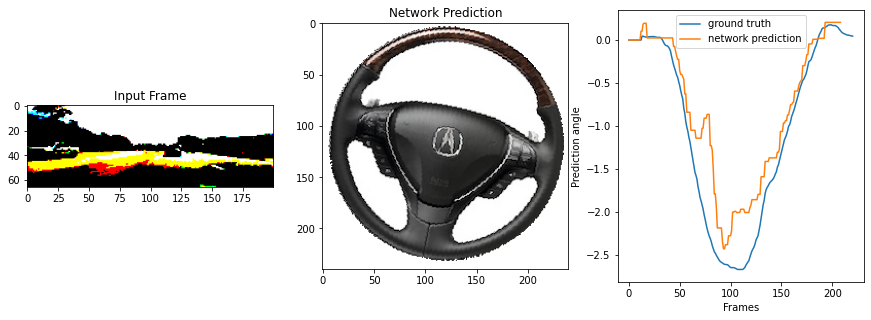

In [12]:
if loihi2_is_available:
    run_config = CustomHwRunConfig()
else:
    run_config = CustomSimRunConfig()
net.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
output = output_logger.data.get().flatten()
gts = gt_logger.data.get().flatten()
net.stop()

## Evaluate Results
Plot and compare the results with the dataset ground truth.

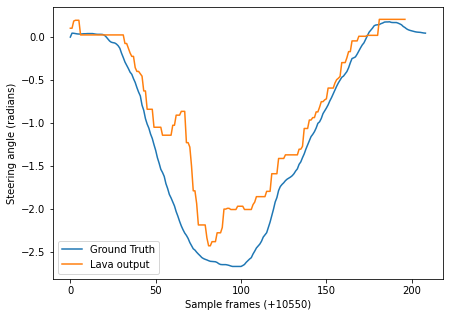

In [13]:
plt.figure(figsize=(7, 5))
plt.plot(np.array(gts), label='Ground Truth')
plt.plot(np.array(output[out_offset:]).flatten(), label='Lava output')
plt.xlabel(f'Sample frames (+10550)')
plt.ylabel('Steering angle (radians)')
plt.legend()
